可以分几步进行优化，产生不同版本的代码，
在不同环境中、不同批次 运行来对比(对比各个版本代码的输出验证、推理时间、推理吞吐量和 GPU 内存使用情况)。


优化步数包括：  

1. yolo 批量处理
2. 使用CUDA加速的背景减除器
3. yolo用tensorRT  
4. 3d 坐标用Cupy代替NumPy,
5. 批量计算3d位置
6. 使用pyCuda  计算3d位置
7. 合并yolo 和3d计算在gpu.
8. Numba（JIT）  
9. cuBLA(高效执行线性代数运算，例如矩阵乘法、求逆、特征值分解等可以与 PyCUDA 或 CuPy 结合)  
10. cuDNN(主流深度学习框架已经内置支持)

第一类（通用 GPU 加速库和技术）：Numba（JIT），cuBLAS，cuDNN
第二类（YOLO 优化）：YOLO 批量处理，YOLO 用 TensorRT
第三类（3D 坐标计算加速）：3D 坐标用 Cupy 代替 NumPy，批量计算 3D 位置，使用 PyCUDA 计算 3D 位置，合并 YOLO 和 3D 计算在 GPU 上


1.	GPU 加速技术：
    o	使用CUDA加速
        1.	使用CUDA加速的背景减除器
        2.	使用pyCuda
    o	使用其他GPU加速库
        1.	 用Cupy代替NumPy
        2.	 cuBLAS（高效执行线性代数运算）
2.	深度学习模型优化：
    o	YOLO模型优化
        1.	YOLO批量处理
        2.	YOLO用TensorRT（ONNX）
    o	深度学习库优化
        1.	cuDNN（pyTorch已经内置支持）
3.	算法优化：
    o	批处理优化 ( 批量计算3d位置)
    o	计算优化 , Numba（JIT）
4. 整体流程优化：
    o	在GPU合并YOLO和3d计算
   

这种分类方式可以帮助我们更好地理解每种优化方法的focus和应用领域：
1.	GPU加速技术主要关注如何充分利用GPU的并行计算能力。
2.	深度学习模型优化专注于提高YOLO等深度学习模型的推理速度。
3.	算法优化着眼于改进计算方法，提高整体效率。
4.	整体流程优化则考虑了如何减少CPU和GPU之间的数据传输，提高整个处理流程的效率。



In [38]:
local = False

r_path = ""
if not local:
    from google.colab import drive
    drive.mount('/content/drive')
    r_path = '/content/drive/MyDrive/Colab Notebooks/STEM/gpu/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import cv2
import numpy as np
import os
import json
from ultralytics import YOLO
import torch
import logging
import time


# 禁用YOLO的日志
logging.getLogger('ultralytics').setLevel(logging.WARNING)
save_dir=r_path +"results"



def calculate_speed(position, prev_position, time_diff):
    if prev_position is not None:
        distance = np.linalg.norm(position - prev_position)  # 计算3D距离
        speed = distance / time_diff  # 计算速度（米/秒）
        return speed, distance
    return None, None

# 将旋转矩阵和平移向量转换为投影矩阵
def get_projection_matrix(camera_matrix, rotation_matrix, translation_vector):
    Rt = np.hstack((rotation_matrix, translation_vector.reshape(-1, 1)))  # 构建 [R|t] 矩阵
    proj_matrix = np.dot(camera_matrix, Rt)  # 计算投影矩阵 P = K * [R|t]
    return proj_matrix

# 从JSON文件中读取相机内参
def load_camera_calibration(file_name):
    with open(file_name, 'r') as json_file:
        calibration_data = json.load(json_file)
        camera_matrix = np.array(calibration_data["camera_matrix"])
        dist_coeffs = np.array(calibration_data["dist_coeffs"])
    return camera_matrix, dist_coeffs


def preload_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  # 获取视频帧率
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # 分割为左上角、右上角、左下角
        height, width = frame.shape[:2]
        width_third = width // 2
        height_half = height // 2

        frame_0 = frame[:height_half, :width_third]  # 左上角
        frame_1 = frame[:height_half, width_third:]  # 右上角
        frame_2 = frame[height_half:, :width_third]  # 左下角

        frames.append((frame_0, frame_1, frame_2))
    cap.release()
    return frames, fps



# 假设已经实现了 process_frame_pytorch, process_frame_tensorrt, process_frame_pycuda 函数

def evaluate_model(process_frame_func, frame_left, frame_right, proj_matrix_left, proj_matrix_right, ground_truth, num_frames=100):
    torch.cuda.reset_peak_memory_stats()
    calculated_output = process_frame_func(frame_left, frame_right, proj_matrix_left, proj_matrix_right)
    output_is_correct = np.allclose(calculated_output, ground_truth, atol=1e-2)

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    start_event.record()
    process_frame_func(frame_left, frame_right, proj_matrix_left, proj_matrix_right)
    end_event.record()

    torch.cuda.synchronize()
    inference_time = start_event.elapsed_time(end_event) / 1000

    frames = [(frame_left, frame_right) for _ in range(num_frames)]
    start_time = time.time()
    for f_left, f_right in frames:
        process_frame_func(f_left, f_right, proj_matrix_left, proj_matrix_right)
    end_time = time.time()

    total_time = end_time - start_time
    throughput = num_frames / total_time

    current_memory = torch.cuda.memory_allocated() / 1e6
    peak_memory = torch.cuda.max_memory_allocated() / 1e6

    return {
        "Output Correct": output_is_correct,
        "Inference Time (s)": inference_time,
        "Throughput (frames/s)": throughput,
        "Current Memory Usage (MB)": current_memory,
        "Peak Memory Usage (MB)": peak_memory
    }



# 初始化YOLO模型
confidence_threshold = 0.1
model_path = r_path+"best.pt"
model = YOLO(model_path)

# 使用背景减除器，配置参数
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=25, detectShadows=False)
# 视频路径
video_path = r_path+"combined_video_3c_play_pp.mp4"  # 使用新的视频路径
frames, fps = preload_video_frames(video_path)
frame_time = 1.0 / fps  # 计算每帧的时间间隔

# 从JSON文件中读取左右相机的内参
left_camera_matrix, left_dist_coeffs = load_camera_calibration(r_path+'camera_1_params.json')
right_camera_matrix, right_dist_coeffs = load_camera_calibration(r_path+'camera_2_params.json')

# 从JSON文件中读取左右相机的外参
with open(r_path+'camera_1_params.json', 'r') as f:
    left_data = json.load(f)
left_rotation_matrix = np.array(left_data["rotation_matrix"])
left_translation_vector = np.array(left_data["translation_vector"])

with open(r_path+'camera_2_params.json', 'r') as f:
    right_data = json.load(f)
right_rotation_matrix = np.array(right_data["rotation_matrix"])
right_translation_vector = np.array(right_data["translation_vector"])

# 计算左右相机的投影矩阵
proj_matrix_left = get_projection_matrix(left_camera_matrix, left_rotation_matrix, left_translation_vector)
proj_matrix_right = get_projection_matrix(right_camera_matrix, right_rotation_matrix, right_translation_vector)




## 1.定义运行测试并保存结果的函数
首先，创建一个函数来执行每个版本的测试，并将结果保存到文件中。这个函数会在每个不同的环境下运行，并将结果存储为JSON或CSV文件。

In [40]:
def run_test_and_save_results(process_frame_func, frames, proj_matrix_left, proj_matrix_right, ground_truth, version_name, gpu_name):
    # 确保保存结果的目录存在
    os.makedirs(save_dir, exist_ok=True)

    # 记录开始时间和初始内存使用
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()
    initial_memory = torch.cuda.memory_allocated()

    # 运行测试并获取3D点集
    all_3d_points = process_frame_func(frames, proj_matrix_left, proj_matrix_right, ground_truth)

    # 记录结束时间和内存使用
    end_time = time.time()
    final_memory = torch.cuda.memory_allocated()
    peak_memory = torch.cuda.max_memory_allocated()

    # 计算误差指标（例如均方误差）
    errors = np.linalg.norm(np.array(all_3d_points) - np.array(ground_truth), axis=-1)
    mean_error = np.mean(errors)
    max_error = np.max(errors)

    # 计算性能指标
    inference_time = end_time - start_time
    throughput = len(frames) / inference_time  # 每秒处理帧数

    # 记录其他性能指标
    results = {
        "Version": version_name,
        "GPU": gpu_name,
        "Mean Error": mean_error,
        "Max Error": max_error,
        "Inference Time (s)": inference_time,
        "Throughput (frames/s)": throughput,
        "Initial Memory Usage (MB)": initial_memory / (1024 ** 2),
        "Final Memory Usage (MB)": final_memory / (1024 ** 2),
        "Peak Memory Usage (MB)": peak_memory / (1024 ** 2)
    }

    # 保存结果为JSON文件
    result_file = os.path.join(save_dir, f"{version_name}_{gpu_name}.json")
    with open(result_file, "w") as f:
        json.dump(results, f, indent=4)

    print(f"Results saved to {result_file}")


## 2. 在每个环境中运行测试
在每个不同的环境中手动运行以下代码块，切换到不同的GPU和优化版本，并保存结果。每次运行后，结果将被保存到指定的文件夹中。

### 2.1 baseline code

In [41]:
def process_frame_base(frames, proj_matrix_left, proj_matrix_right, ground_truth):
    all_3d_points = []
    prev_point_2d_left = None
    prev_point_2d_right = None

    for i in range(0, len(frames), 2):
        frame_left = frames[i]
        frame_right = frames[i + 1] if (i + 1) < len(frames) else frames[i]

        # YOLO推理
        results_left = model(frame_left)
        results_right = model(frame_right)

        # 提取检测到的乒乓球的2D坐标
        points_2d_left = []
        points_2d_right = []

        # 处理左摄像头结果
        if len(results_left[0].boxes) > 0:
            for box in results_left[0].boxes:
                point_2d_left = (int((box.xyxy[0][0] + box.xyxy[0][2]) / 2), int((box.xyxy[0][1] + box.xyxy[0][3]) / 2))
                points_2d_left.append(point_2d_left)
            prev_point_2d_left = points_2d_left[0]  # 更新前一次检测的点
        else:
            if prev_point_2d_left is not None:
                points_2d_left.append(prev_point_2d_left)  # 使用上次的检测点
            else:
                points_2d_left.append((0, 0))  # 如果没有前次记录，则默认(0, 0)

        # 处理右摄像头结果
        if len(results_right[0].boxes) > 0:
            for box in results_right[0].boxes:
                point_2d_right = (int((box.xyxy[0][0] + box.xyxy[0][2]) / 2), int((box.xyxy[0][1] + box.xyxy[0][3]) / 2))
                points_2d_right.append(point_2d_right)
            prev_point_2d_right = points_2d_right[0]  # 更新前一次检测的点
        else:
            if prev_point_2d_right is not None:
                points_2d_right.append(prev_point_2d_right)  # 使用上次的检测点
            else:
                points_2d_right.append((0, 0))  # 如果没有前次记录，则默认(0, 0)

        # 计算3D位置
        points_3d = []
        for point_2d_left, point_2d_right in zip(points_2d_left, points_2d_right):
            point_3d = calculate_3d_position(proj_matrix_left, proj_matrix_right, point_2d_left, point_2d_right)
            points_3d.append(point_3d)
            print(f"3D Coordinates: {point_3d}")  # 输出每次的3D坐标

        all_3d_points.append(points_3d)

    return all_3d_points



# calculate_3d_position 的基础实现
def calculate_3d_position(proj_matrix_left, proj_matrix_right, point_2d_left, point_2d_right):
    points_2d_left = np.array([point_2d_left], dtype=np.float32).T
    points_2d_right = np.array([point_2d_right], dtype=np.float32).T
    point_4d_homogeneous = cv2.triangulatePoints(proj_matrix_left, proj_matrix_right, points_2d_left, points_2d_right)
    point_3d = point_4d_homogeneous[:3] / point_4d_homogeneous[3]  # 转换为非齐次坐标
    return point_3d.flatten()




In [42]:


ground_truth_file = os.path.join(r_path, "ground_truth.json")

# 检查ground_truth文件是否存在
if os.path.exists(ground_truth_file):
    print("Loading existing ground_truth...")
    with open(ground_truth_file, 'r') as f:
        ground_truth = json.load(f)
else:
    print("ground_truth.json not found. Calculating ground_truth using process_frame_base...")

    # 预加载视频帧
    frames, fps = preload_video_frames(video_path)

    # 使用基础版本生成ground_truth
    ground_truth = process_frame_base(frames, proj_matrix_left, proj_matrix_right, None)

    # ground_truth 可能是 NumPy 数组，转换为列表格式
    ground_truth = np.array(ground_truth).tolist()

    # 保存ground_truth为JSON格式
    with open(ground_truth_file, 'w') as f:
        json.dump(ground_truth, f, indent=4)

    print("ground_truth.json saved.")

Loading existing ground_truth...


In [43]:
# 设置环境相关的变量
version_name = "Base"
gpu_name = "A100"

# 运行优化版本并保存结果
run_test_and_save_results(process_frame_base, frames, proj_matrix_left, proj_matrix_right, ground_truth, version_name, gpu_name)

3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [     5.3822      2.1715     0.77041]
3D Coordinates: [     5.3822      2.1715     0.77041]
3D Coordinates: [     1.2256      1.2453      0.3322]
3D Coordinates: [     1.2256

### 2.1 第一个变体，Numba优化

这个优化版本主要做了以下修改:

1.使用@jit(nopython=True)装饰器对calculate_3d_position_numba函数进行了Numba优化。这会将Python代码编译成机器代码,大大提高计算速度。
2.由于Numba不支持cv2.triangulatePoints,我们手动实现了这个函数的逻辑。这个实现使用了SVD(奇异值分解)来计算3D点。

In [44]:
 import numpy as np
import cv2
from numba import jit

@jit(nopython=True)
def calculate_3d_position_numba(proj_matrix_left, proj_matrix_right, point_2d_left, point_2d_right):
    points_2d_left = np.array([point_2d_left], dtype=np.float32).T
    points_2d_right = np.array([point_2d_right], dtype=np.float32).T

    # 手动实现cv2.triangulatePoints的逻辑
    A = np.zeros((4, 4))
    for i in range(4):
        A[0, i] = point_2d_left[0] * proj_matrix_left[2, i] - proj_matrix_left[0, i]
        A[1, i] = point_2d_left[1] * proj_matrix_left[2, i] - proj_matrix_left[1, i]
        A[2, i] = point_2d_right[0] * proj_matrix_right[2, i] - proj_matrix_right[0, i]
        A[3, i] = point_2d_right[1] * proj_matrix_right[2, i] - proj_matrix_right[1, i]

    _, _, Vt = np.linalg.svd(A)
    point_4d_homogeneous = Vt[-1]
    point_3d = point_4d_homogeneous[:3] / point_4d_homogeneous[3]
    return point_3d

def process_frame_numba(frames, proj_matrix_left, proj_matrix_right, ground_truth):
    all_3d_points = []
    prev_point_2d_left = None
    prev_point_2d_right = None

    for i in range(0, len(frames), 2):
        frame_left = frames[i]
        frame_right = frames[i + 1] if (i + 1) < len(frames) else frames[i]

        # YOLO推理
        results_left = model(frame_left)
        results_right = model(frame_right)

        # 提取检测到的乒乓球的2D坐标
        points_2d_left = []
        points_2d_right = []

        # 处理左摄像头结果
        if len(results_left[0].boxes) > 0:
            box = results_left[0].boxes[0]
            point_2d_left = (int((box.xyxy[0][0] + box.xyxy[0][2]) / 2), int((box.xyxy[0][1] + box.xyxy[0][3]) / 2))
            points_2d_left.append(point_2d_left)
            prev_point_2d_left = point_2d_left
        else:
            points_2d_left.append(prev_point_2d_left if prev_point_2d_left is not None else (0, 0))

        # 处理右摄像头结果
        if len(results_right[0].boxes) > 0:
            box = results_right[0].boxes[0]
            point_2d_right = (int((box.xyxy[0][0] + box.xyxy[0][2]) / 2), int((box.xyxy[0][1] + box.xyxy[0][3]) / 2))
            points_2d_right.append(point_2d_right)
            prev_point_2d_right = point_2d_right
        else:
            points_2d_right.append(prev_point_2d_right if prev_point_2d_right is not None else (0, 0))

        # 计算3D位置
        points_3d = []
        for point_2d_left, point_2d_right in zip(points_2d_left, points_2d_right):
            point_3d = calculate_3d_position_numba(proj_matrix_left, proj_matrix_right, point_2d_left, point_2d_right)
            points_3d.append(point_3d)
            print(f"3D Coordinates: {point_3d}")  # 输出每次的3D坐标

        all_3d_points.append(points_3d)

    return all_3d_points

# 设置环境相关的变量
version_name = "Numba_Optimized"
gpu_name = "A100"

# 运行优化版本并保存结果
run_test_and_save_results(process_frame_numba, frames, proj_matrix_left, proj_matrix_right, ground_truth, version_name, gpu_name)


3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [      1.099    -0.17634     0.84644]
3D Coordinates: [     5.3822      2.1715     0.77041]
3D Coordinates: [     5.3822      2.1715     0.77041]
3D Coordinates: [     1.2256      1.2453      0.3322]
3D Coordinates: [     1.2256

### 2.3 cuBLA
1.使用了cupy库,这是NumPy的GPU加速版本。它允许我们在GPU上进行大部分数组操作。
2.将投影矩阵转换为GPU上的cupy数组,以减少CPU和GPU之间的数据传输。
3.重写了calculate_3d_position函数,现在命名为calculate_3d_position_cublas。这个新函数使用cupy的线性代数库来求解3D点的位置,这比原来的CV2方法更快。
4.使用了cupy的最小二乘求解器(cp_linalg.lstsq)来计算3D坐标,这利用了cuBLAS的优化。
5.保持了原代码的整体结构和逻辑,主要更改了数据处理和计算的部分。

In [45]:
import numpy as np
import cv2
import cupy as cp
from cupyx.scipy import linalg as cp_linalg

def process_frame_cublas(frames, proj_matrix_left, proj_matrix_right, ground_truth):
    all_3d_points = []
    prev_point_2d_left = None
    prev_point_2d_right = None

    # 将投影矩阵转换为GPU上的cupy数组
    proj_matrix_left_gpu = cp.asarray(proj_matrix_left)
    proj_matrix_right_gpu = cp.asarray(proj_matrix_right)

    for i in range(0, len(frames), 2):
        frame_left = frames[i]
        frame_right = frames[i + 1] if (i + 1) < len(frames) else frames[i]

        # YOLO推理 (假设model已经是GPU版本)
        results_left = model(frame_left)
        results_right = model(frame_right)

        # 提取检测到的乒乓球的2D坐标
        points_2d_left = []
        points_2d_right = []

        # 处理左摄像头结果
        if len(results_left[0].boxes) > 0:
            for box in results_left[0].boxes:
                point_2d_left = (int((box.xyxy[0][0] + box.xyxy[0][2]) / 2), int((box.xyxy[0][1] + box.xyxy[0][3]) / 2))
                points_2d_left.append(point_2d_left)
            prev_point_2d_left = points_2d_left[0]
        else:
            points_2d_left.append(prev_point_2d_left if prev_point_2d_left is not None else (0, 0))

        # 处理右摄像头结果
        if len(results_right[0].boxes) > 0:
            for box in results_right[0].boxes:
                point_2d_right = (int((box.xyxy[0][0] + box.xyxy[0][2]) / 2), int((box.xyxy[0][1] + box.xyxy[0][3]) / 2))
                points_2d_right.append(point_2d_right)
            prev_point_2d_right = points_2d_right[0]
        else:
            points_2d_right.append(prev_point_2d_right if prev_point_2d_right is not None else (0, 0))

        # 计算3D位置
        points_3d = []
        for point_2d_left, point_2d_right in zip(points_2d_left, points_2d_right):
            point_3d = calculate_3d_position_cublas(proj_matrix_left_gpu, proj_matrix_right_gpu, point_2d_left, point_2d_right)
            points_3d.append(point_3d)
            print(f"3D Coordinates: {point_3d}")

        all_3d_points.append(points_3d)

    return all_3d_points

def calculate_3d_position_cublas(proj_matrix_left, proj_matrix_right, point_2d_left, point_2d_right):
    points_2d_left = cp.asarray([point_2d_left], dtype=cp.float32).T
    points_2d_right = cp.asarray([point_2d_right], dtype=cp.float32).T

    # 构建线性方程组
    A = cp.vstack((
        proj_matrix_left[0] - point_2d_left[0] * proj_matrix_left[2],
        proj_matrix_left[1] - point_2d_left[1] * proj_matrix_left[2],
        proj_matrix_right[0] - point_2d_right[0] * proj_matrix_right[2],
        proj_matrix_right[1] - point_2d_right[1] * proj_matrix_right[2]
    ))

    # 使用cupy的线性代数求解器
    #_, x = cp_linalg.lstsq(A, cp.zeros((4, 1)))

    x = cp.linalg.solve(A.T @ A, A.T @ cp.zeros((4, 1)))

    point_3d = x[:3] / x[3]  # 转换为非齐次坐标
    return cp.asnumpy(point_3d.flatten())

# 设置环境相关的变量
version_name = "cuBLAS_Optimized"
gpu_name = "A100"

# 运行优化版本并保存结果
run_test_and_save_results(process_frame_cublas, frames, proj_matrix_left, proj_matrix_right, ground_truth, version_name, gpu_name)


3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan         nan         nan]
3D Coordinates: [        nan

### 2.4 pyCUDA
1.创建了一个CUDA核函数calculate_3d_position，用于并行计算3D坐标。
2.使用pycuda.compiler.SourceModule编译CUDA代码。
3.将投影矩阵预先复制到GPU内存中，避免重复传输。
4.在主循环中，将2D坐标数据批量传输到GPU，然后调用CUDA核函数进行并行计算。
5.计算完成后，将结果从GPU复制回主机内存。

In [53]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [54]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660544 sha256=2bb7af1ba6fe799d0c717fb966779b329b822e3f49f7a0fb1c420179e651ad5b
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


In [59]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import torch

# Load YOLO model and move to GPU
model_path = r_path + "best.pt"
model = YOLO(model_path).to('cuda')

# CUDA kernel for 3D position calculation
cuda_code = """
__global__ void calculate_3d_position(float *proj_matrix_left, float *proj_matrix_right,
                                      float *points_2d_left, float *points_2d_right,
                                      float *points_3d, int num_points) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < num_points) {
        float x1 = points_2d_left[idx * 2];
        float y1 = points_2d_left[idx * 2 + 1];
        float x2 = points_2d_right[idx * 2];
        float y2 = points_2d_right[idx * 2 + 1];

        // Simplified triangulation (you may need to implement a more accurate method)
        float X = (x1 * proj_matrix_right[8] - proj_matrix_left[8]) /
                  (proj_matrix_left[0] - x1 * proj_matrix_left[8]);
        float Y = (y1 * proj_matrix_right[9] - proj_matrix_left[9]) /
                  (proj_matrix_left[4] - y1 * proj_matrix_left[9]);
        float Z = (proj_matrix_left[10] - x1 * proj_matrix_right[10]) /
                  (proj_matrix_left[8] - x1 * proj_matrix_right[8]);

        points_3d[idx * 3] = X;
        points_3d[idx * 3 + 1] = Y;
        points_3d[idx * 3 + 2] = Z;
    }
}
"""

# Compile CUDA kernel
mod = SourceModule(cuda_code)
calculate_3d_position_kernel = mod.get_function("calculate_3d_position")

def process_frame_pycuda(frames, proj_matrix_left, proj_matrix_right, ground_truth):
    all_3d_points = []
    prev_point_2d_left = None
    prev_point_2d_right = None

    # Ensure we're using the same CUDA device
    cuda.init()
    device = cuda.Device(0)  # Assuming you're using the first GPU
    ctx = device.make_context()

    try:
        # Prepare CUDA arrays for projection matrices
        proj_matrix_left_gpu = cuda.mem_alloc(proj_matrix_left.nbytes)
        proj_matrix_right_gpu = cuda.mem_alloc(proj_matrix_right.nbytes)
        cuda.memcpy_htod(proj_matrix_left_gpu, proj_matrix_left)
        cuda.memcpy_htod(proj_matrix_right_gpu, proj_matrix_right)

        for i in range(0, len(frames), 2):
            frame_left = frames[i]
            frame_right = frames[i + 1] if (i + 1) < len(frames) else frames[i]

            # YOLO inference
            results_left = model(frame_left)
            results_right = model(frame_right)

            # Extract 2D coordinates
            points_2d_left = []
            points_2d_right = []

            # Process left camera results
            if len(results_left[0].boxes) > 0:
                for box in results_left[0].boxes:
                    point_2d_left = (int((box.xyxy[0][0] + box.xyxy[0][2]) / 2), int((box.xyxy[0][1] + box.xyxy[0][3]) / 2))
                    points_2d_left.append(point_2d_left)
                prev_point_2d_left = points_2d_left[0]
            else:
                points_2d_left.append(prev_point_2d_left if prev_point_2d_left is not None else (0, 0))

            # Process right camera results
            if len(results_right[0].boxes) > 0:
                for box in results_right[0].boxes:
                    point_2d_right = (int((box.xyxy[0][0] + box.xyxy[0][2]) / 2), int((box.xyxy[0][1] + box.xyxy[0][3]) / 2))
                    points_2d_right.append(point_2d_right)
                prev_point_2d_right = points_2d_right[0]
            else:
                points_2d_right.append(prev_point_2d_right if prev_point_2d_right is not None else (0, 0))

            # Prepare data for CUDA
            num_points = len(points_2d_left)
            points_2d_left_array = np.array(points_2d_left, dtype=np.float32).flatten()
            points_2d_right_array = np.array(points_2d_right, dtype=np.float32).flatten()
            points_3d = np.zeros(num_points * 3, dtype=np.float32)

            # Allocate memory on GPU
            points_2d_left_gpu = cuda.mem_alloc(points_2d_left_array.nbytes)
            points_2d_right_gpu = cuda.mem_alloc(points_2d_right_array.nbytes)
            points_3d_gpu = cuda.mem_alloc(points_3d.nbytes)

            # Copy data to GPU
            cuda.memcpy_htod(points_2d_left_gpu, points_2d_left_array)
            cuda.memcpy_htod(points_2d_right_gpu, points_2d_right_array)

            # Launch kernel
            block_size = 256
            grid_size = (num_points + block_size - 1) // block_size
            calculate_3d_position_kernel(
                proj_matrix_left_gpu, proj_matrix_right_gpu,
                points_2d_left_gpu, points_2d_right_gpu,
                points_3d_gpu, np.int32(num_points),
                block=(block_size, 1, 1), grid=(grid_size, 1)
            )

            # Copy result back to host
            cuda.memcpy_dtoh(points_3d, points_3d_gpu)

            # Reshape and append results
            points_3d = points_3d.reshape(-1, 3)
            all_3d_points.append(points_3d)

            print(f"3D Coordinates: {points_3d}")

    finally:
        # Clean up
        ctx.pop()

    return all_3d_points

# 设置环境相关的变量
version_name = "PyCUDA_Optimized"
gpu_name = "A100"

# 运行优化版本并保存结果
run_test_and_save_results(process_frame_pycuda, frames, proj_matrix_left, proj_matrix_right, ground_truth, version_name, gpu_name)


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM_STREAM_MISMATCH

### 2.4 combinedProcessor
1. 创建了一个CombinedProcessor类，它包含了YOLO处理和3D坐标计算的逻辑。
2. YOLO模型和3D坐标计算都在GPU上进行，减少了CPU和GPU之间的数据传输。
3. 使用PyTorch的nn.Module来组织代码，使得整个处理流程可以更好地利用GPU加速。
4. 2D点的提取也在GPU上进行，进一步减少了CPU的参与。
5. 整个处理过程都在torch.no_grad()上下文中进行，避免了不必要的梯度计算，提高了推理速度。

这个优化版本应该能显著减少CPU和GPU之间的数据传输，从而提高整体性能。但请注意，这个版本假设您的YOLO模型是PyTorch模型，并且可以在GPU上运行。如果您的YOLO模型使用不同的框架或无法直接在GPU上运行，可能需要进一步调整。

另外，这个版本可能需要更多的GPU内存，因为它一次性将所有数据加载到GPU上。如果遇到内存问题，可能需要考虑分批处理数据。

In [62]:
import torch
import torch.nn as nn
import cv2
import numpy as np

class YOLOProcessing(nn.Module):
    def __init__(self, yolo_model):
        super().__init__()
        self.yolo_model = yolo_model

    def forward(self, frames):
        return self.yolo_model(frames)

class CoordinateCalculation(nn.Module):
    def __init__(self, proj_matrix_left, proj_matrix_right):
        super().__init__()
        self.proj_matrix_left = torch.from_numpy(proj_matrix_left).float().cuda()
        self.proj_matrix_right = torch.from_numpy(proj_matrix_right).float().cuda()

    def forward(self, points_2d_left, points_2d_right):
        points_4d = cv2.triangulatePoints(self.proj_matrix_left.cpu().numpy(),
                                          self.proj_matrix_right.cpu().numpy(),
                                          points_2d_left.cpu().numpy(),
                                          points_2d_right.cpu().numpy())
        points_3d = points_4d[:3] / points_4d[3]
        return torch.from_numpy(points_3d).float().cuda()

class CombinedProcessor(nn.Module):
    def __init__(self, yolo_model, proj_matrix_left, proj_matrix_right):
        super().__init__()
        self.yolo_processing = YOLOProcessing(yolo_model)
        self.coordinate_calculation = CoordinateCalculation(proj_matrix_left, proj_matrix_right)

    def forward(self, frames_left, frames_right):
        results_left = self.yolo_processing(frames_left)
        results_right = self.yolo_processing(frames_right)

        points_2d_left = self.extract_2d_points(results_left)
        points_2d_right = self.extract_2d_points(results_right)

        points_3d = self.coordinate_calculation(points_2d_left, points_2d_right)

        return points_3d

    def extract_2d_points(self, results):
        points = []
        for result in results:
            if len(result.boxes) > 0:
                box = result.boxes[0]
                point = torch.tensor([(box.xyxy[0][0] + box.xyxy[0][2]) / 2,
                                      (box.xyxy[0][1] + box.xyxy[0][3]) / 2]).cuda()
            else:
                point = torch.tensor([0, 0]).cuda()
            points.append(point)
        return torch.stack(points)

def process_frame_optimized(frames, proj_matrix_left, proj_matrix_right, ground_truth):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    combined_processor = CombinedProcessor(model, proj_matrix_left, proj_matrix_right).to(device)

    all_3d_points = []

    for i in range(0, len(frames), 2):
        frame_left = frames[i].to(device)
        frame_right = frames[i + 1].to(device) if (i + 1) < len(frames) else frames[i].to(device)

        with torch.no_grad():
            points_3d = combined_processor(frame_left.unsqueeze(0), frame_right.unsqueeze(0))

        all_3d_points.append(points_3d.cpu().numpy())
        print(f"3D Coordinates: {points_3d.cpu().numpy()}")

    return all_3d_points

# 设置环境相关的变量
version_name = "combinedProcessor"
gpu_name = "A100"

# 运行优化版本并保存结果
run_test_and_save_results(process_frame_optimized, frames, proj_matrix_left, proj_matrix_right, ground_truth, version_name, gpu_name)

AttributeError: 'tuple' object has no attribute 'to'

### 2.10 TensorRT

In [ ]:

from torch2trt import torch2trt

# 转换为TensorRT模型
def convert_to_trt_model(model, input_size=(3, 640, 640)):
    model.eval()
    dummy_input = torch.randn(1, *input_size).cuda()  # 模拟输入，用于模型转换
    model_trt = torch2trt(model, [dummy_input], max_batch_size=1)  # 转换为TensorRT模型
    return model_trt

# 将YOLO模型转换为TensorRT模型
model_trt = convert_to_trt_model(model)

def process_frame_trt(frames, proj_matrix_left, proj_matrix_right, ground_truth):
    all_3d_points = []
    prev_point_2d_left = None
    prev_point_2d_right = None

    for i in range(0, len(frames), 2):
        frame_left = frames[i]
        frame_right = frames[i + 1] if (i + 1) < len(frames) else frames[i]

        # 使用TensorRT优化后的YOLO模型进行推理
        results_left = model_trt(torch.tensor(frame_left).cuda().unsqueeze(0))
        results_right = model_trt(torch.tensor(frame_right).cuda().unsqueeze(0))

        points_2d_left = []
        points_2d_right = []

        # 处理左摄像头结果
        for box in results_left[0].boxes:
            point_2d_left = (
                int((box.xyxy[0][0] + box.xyxy[0][2]) / 2),
                int((box.xyxy[0][1] + box.xyxy[0][3]) / 2)
            )
            points_2d_left.append(point_2d_left)
        prev_point_2d_left = points_2d_left[0] if points_2d_left else prev_point_2d_left

        # 处理右摄像头结果
        for box in results_right[0].boxes:
            point_2d_right = (
                int((box.xyxy[0][0] + box.xyxy[0][2]) / 2),
                int((box.xyxy[0][1] + box.xyxy[0][3]) / 2)
            )
            points_2d_right.append(point_2d_right)
        prev_point_2d_right = points_2d_right[0] if points_2d_right else prev_point_2d_right

        # 使用前一帧的坐标作为回退方案
        if not points_2d_left and prev_point_2d_left:
            points_2d_left.append(prev_point_2d_left)
        if not points_2d_right and prev_point_2d_right:
            points_2d_right.append(prev_point_2d_right)

        # 计算3D位置
        points_3d = []
        for point_2d_left, point_2d_right in zip(points_2d_left, points_2d_right):
            point_3d = calculate_3d_position(proj_matrix_left, proj_matrix_right, point_2d_left, point_2d_right)
            points_3d.append(point_3d)
            logging.info(f"3D Coordinates: {point_3d}")

        all_3d_points.append(points_3d)

    return all_3d_points

# calculate_3d_position 的基础实现
def calculate_3d_position(proj_matrix_left, proj_matrix_right, point_2d_left, point_2d_right):
    points_2d_left = np.array([point_2d_left], dtype=np.float32).T
    points_2d_right = np.array([point_2d_right], dtype=np.float32).T
    point_4d_homogeneous = cv2.triangulatePoints(proj_matrix_left, proj_matrix_right, points_2d_left, points_2d_right)
    point_3d = point_4d_homogeneous[:3] / point_4d_homogeneous[3]  # 转换为非齐次坐标
    return point_3d.flatten()

# 设置环境相关的变量
version_name = "TensorRT"  # 更改为不同的版本名称，如 "YOLO_Batch", "TensorRT", 等
gpu_name = "A100"  # 更改为当前环境的GPU名称，如 "L4", "T4"

# 运行优化版本并保存结果
run_test_and_save_results(process_frame_trt, frames, proj_matrix_left, proj_matrix_right, ground_truth
                          , version_name, gpu_name)

## 3. 加载所有结果并进行比较
在所有环境运行完成后，创建一个Notebook代码块来加载所有保存的结果，并进行对比分析。生成统计图以可视化不同版本和GPU的性能差异。

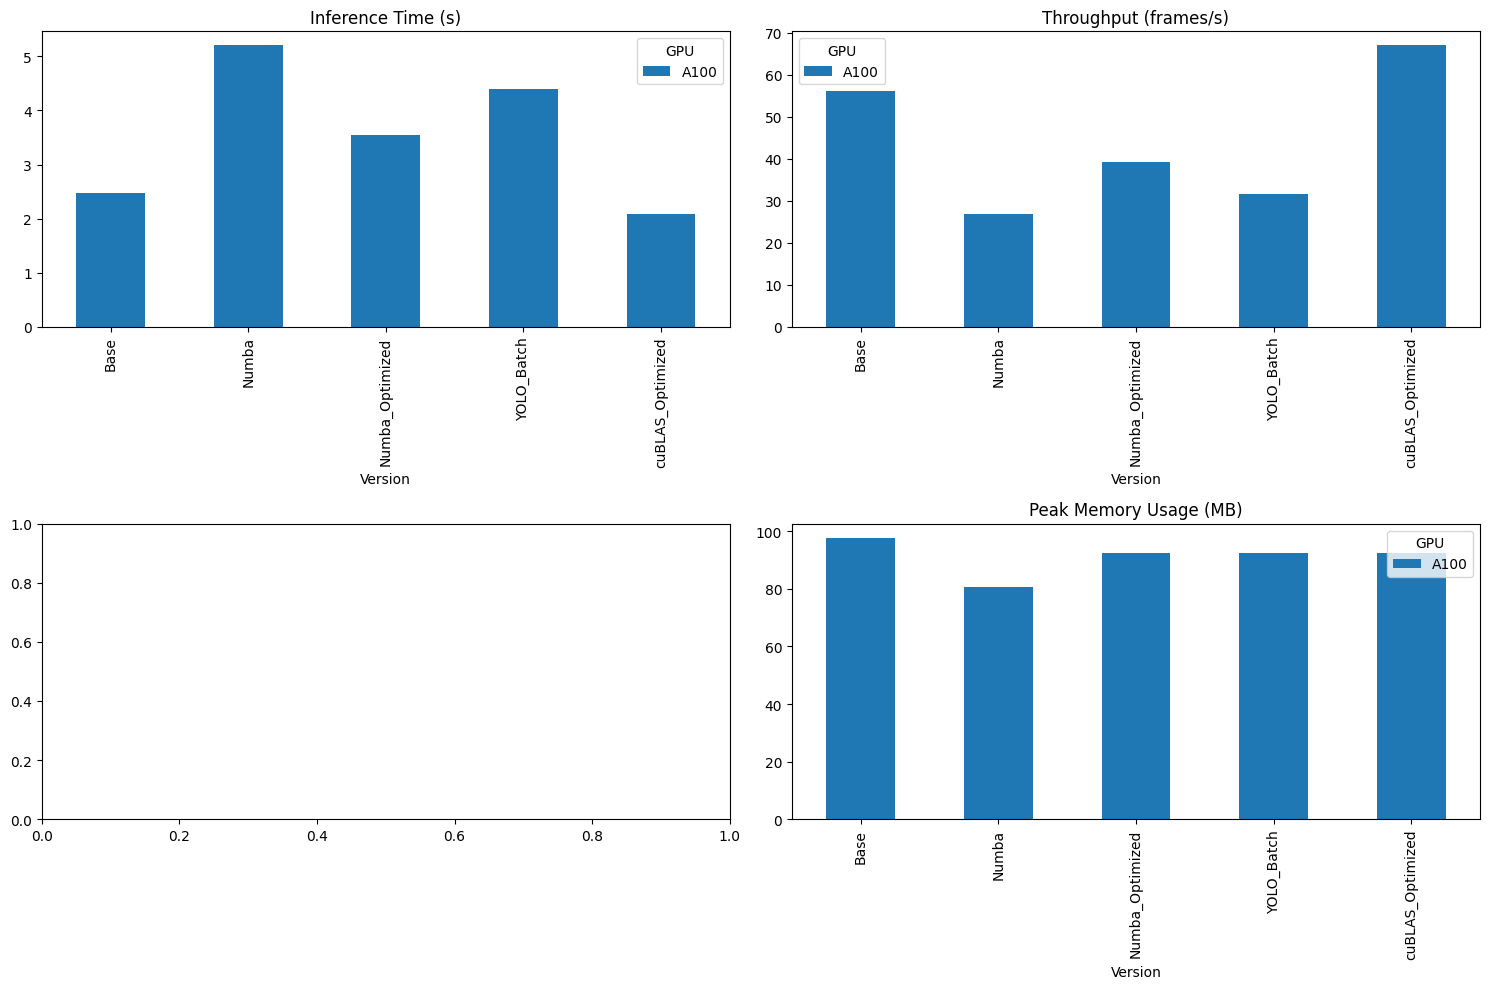

In [63]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

def load_results():
    results = []
    for file_name in os.listdir(save_dir):
        if file_name.endswith(".json"):
            with open(os.path.join(save_dir, file_name), "r") as f:
                result = json.load(f)
                results.append(result)
    return pd.DataFrame(results)

def plot_results(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 推理时间
    df.groupby(["Version", "GPU"])["Inference Time (s)"].mean().unstack().plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title("Inference Time (s)")

    # 吞吐量
    df.groupby(["Version", "GPU"])["Throughput (frames/s)"].mean().unstack().plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title("Throughput (frames/s)")


    # 峰值内存使用
    df.groupby(["Version", "GPU"])["Peak Memory Usage (MB)"].mean().unstack().plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title("Peak Memory Usage (MB)")

    plt.tight_layout()
    plt.show()

# 加载结果并生成图表
df = load_results()
plot_results(df)


4. 执行最终分析
运行所有优化步骤：在不同的GPU环境中依次运行所有优化版本的代码，并将结果保存。
加载并比较结果：在同一个Notebook中加载所有结果文件，比较不同版本和GPU的性能表现。
生成统计图：使用Matplotlib生成推理时间、吞吐量、GPU内存使用情况的比较图表。
5. 总结与报告
通过这些步骤，您可以系统地评估每个优化步骤在不同GPU环境下的效果，并生成可视化图表以更好地理解性能差异。这将帮助您找到最佳的优化策略和硬件配置。